<a href="https://colab.research.google.com/github/Imen-Mourali/Predicting-a-track-s-popularity-from-its-musical-features-/blob/main/Predicting_a_track's_popularity_from_its_musical_features_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting a track's popularity from its musical features 



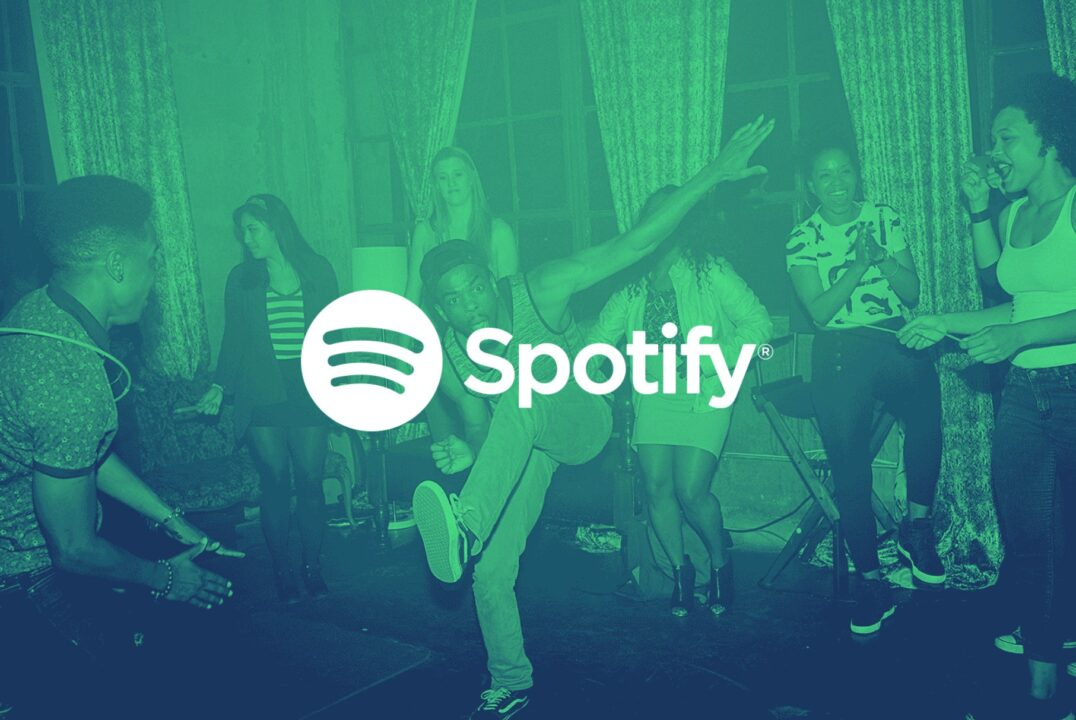

I'm planning to record my first album and upload it on DistroKid that will distribute it to the major streaming services like Spotify, Deezer, Apple Music, iTunes...

I can't help but ask myself theses questions : will my music succeed to reach music lovers ? Will it be heard only in the circle of my friends and family ? Apart from the music genre and the artist, what are the characteristics of popular vs unpopular music ? Can I predict the popularity of my songs ?

Working on Spotify's dataset, i'll be examining data to propose descriptive statistics analysis to evaluate tracks'musical features contributing to their popularity or unpopularity, regardless of their genre or the artist to whom they belong. 

I'll build then Machine Learning models who aim to predict the popularity of a track from its most relevent features. 

To begin with, let's load the metadata about our tracks alongside the track metrics from 2018 to 2020, compiled by The Echo Nest. 

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# 1- Some insights on popular and unpopular tracks
## Preparing the dataset
To prepare our dataset, we will :
- Import 2018, 2019 and 2020 spotify datasets
- Concatenate the three datasets
- Drop duplicates
- Drop all rows with any missing value 
- Return a random sample of 30000 items 
- Create a new categorical feature from "popularity" feature




In [ ]:
# Read 2018, 2019 and 2020 datasets
data2020 = pd.read_csv('/content/drive/MyDrive/Spotify Data_popularity/2020_tracks.csv')
data2019 = pd.read_csv('/content/drive/MyDrive/Spotify Data_popularity/2019_tracks.csv')
data2018 = pd.read_csv('/content/drive/MyDrive/Spotify Data_popularity/2018_tracks.csv')

In [ ]:
# Append rows of 2018, 2019 and 2020 datasets
data = pd.concat([data2018,data2019, data2020], axis=0,ignore_index=True)
# Remove duplicate rows
data.drop_duplicates()
# Randomly select 20000 rows
df = data.dropna().sample(n=20000)
# Inspect the resultant dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 16219 to 2447
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  object 
 1   name              20000 non-null  object 
 2   popularity        20000 non-null  int64  
 3   duration_ms       20000 non-null  int64  
 4   explicit          20000 non-null  int64  
 5   artists           20000 non-null  object 
 6   release_date      20000 non-null  object 
 7   danceability      20000 non-null  float64
 8   key               20000 non-null  object 
 9   acousticness      20000 non-null  float64
 10  instrumentalness  20000 non-null  float64
 11  tempo             20000 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 2.0+ MB


### Creating a new feature from "popularity"
The popularity feature is continous and numerical. We want to split the popularity amount into 5 distinct categories, the new feature "popularity_group" will be categorical. Since these categories will have a natural order (from the lowest to the highest), the variable will be considered as ordinal. 

But first, let's inspect the distribution of the "popularity" feature 

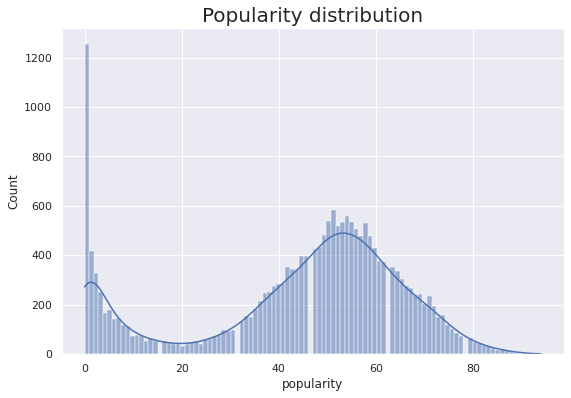

In [ ]:
# Plotting the histogram of the popularity feature
sns.set()
sns.histplot(data=df, x="popularity", bins= 100,kde=True)
plt.title('Popularity distribution', fontsize=20)
sns.set(rc={'figure.figsize':(9,6)})

"popularity" feature has integer values between 0 and 100. Its distribution is bimodal : the most frequent values are 0 and 50.

It would be interesting to investigate tracks with a popularity value equal to zero ! It could be done in another work

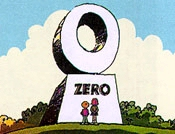

In [ ]:
# Discretizing into equal-sized bins.
category = pd.cut(df.popularity,bins=[0,20,40,60,80,100],labels=['Very low','Low','Moderate','High','Very High'], ordered=True)
# Inserting the new column into the dataframe
df.insert(2,'popularity_group',category)
df = df.dropna()

## Descriptive statistics of the 5 categories by their musical features 
First let's find out how many songs each category contains

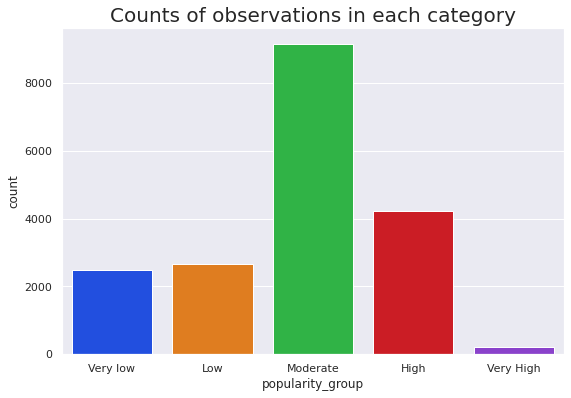

In [ ]:
# Number of tracks in each category
sns.countplot(x="popularity_group",data=df,palette="bright" )
plt.title('Counts of observations in each category', fontsize=20)
sns.set(rc={'figure.figsize':(9,6)})

The mode/most frequent category of popularity is the "Moderate", followed by the "High". There are as many "Low" popular tracks as there are "Very low" popular ones. While tracks with a "Very High" popularity are the rarest ones.

Let's explore tracks'musical features contributing to their popularity or unpopularity




In [ ]:
# The mean of the features'values for each category 
category_mean = df.groupby(by="popularity_group").mean()
category_mean

,popularity,duration_ms,explicit,danceability,acousticness,instrumentalness,tempo
popularity_group,,,,,,,
Very low,6.473747,220011.400401,0.041683,0.563990,0.174691,0.333986,125.116283
Low,33.873208,206558.716981,0.191321,0.650869,0.266767,0.096232,121.536608
Moderate,51.225581,207833.925679,0.234203,0.665032,0.319228,0.038769,120.989107
High,67.667062,203379.628856,0.294969,0.674775,0.290892,0.024331,122.250009
Very High,84.135135,198091.833333,0.409910,0.698676,0.280135,0.012254,122.291640


In [ ]:
# The standard deviation of the features'values for each category 
category_std = df.groupby(by="popularity_group").std()
category_std

,popularity,duration_ms,explicit,danceability,acousticness,instrumentalness,tempo
popularity_group,,,,,,,
Very low,5.227005,167336.826176,0.199905,0.157454,0.286919,0.392756,22.369401
Low,5.138453,74887.602871,0.393415,0.164812,0.263523,0.254968,29.404980
Moderate,5.439560,75642.332163,0.423523,0.147950,0.273427,0.163891,29.558805
High,5.047505,53767.658847,0.456083,0.146831,0.262232,0.121725,30.042205
Very High,2.925892,39866.327198,0.492928,0.120970,0.262722,0.066026,29.519491


Now we will visualize the acousticness, the instrumentalness, the dancebility, the explicit and the tempo means for each category, but let's first understand these features.

### Instrumentalness
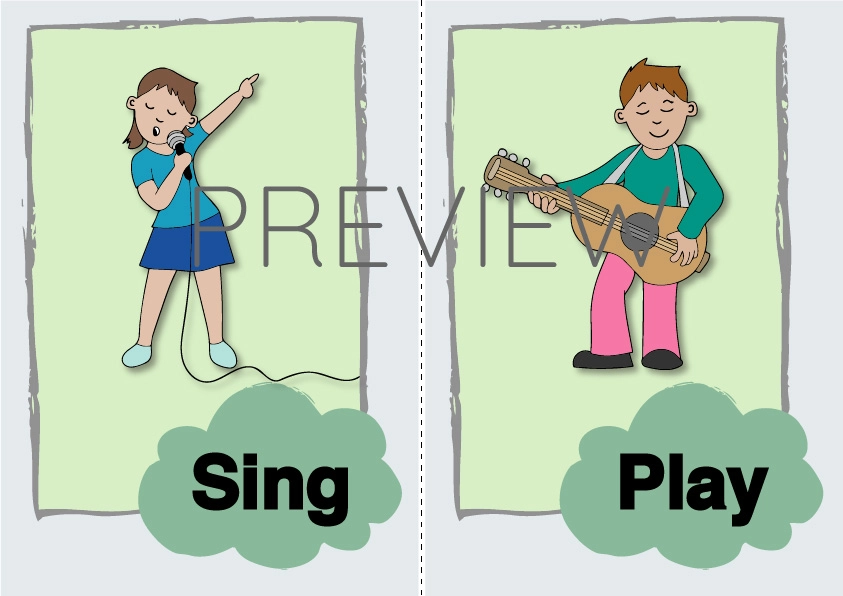

This musical feature is defined as the probability that a track does not contain vocals [2]. It is a float between 0 and 1.


### Acousticness


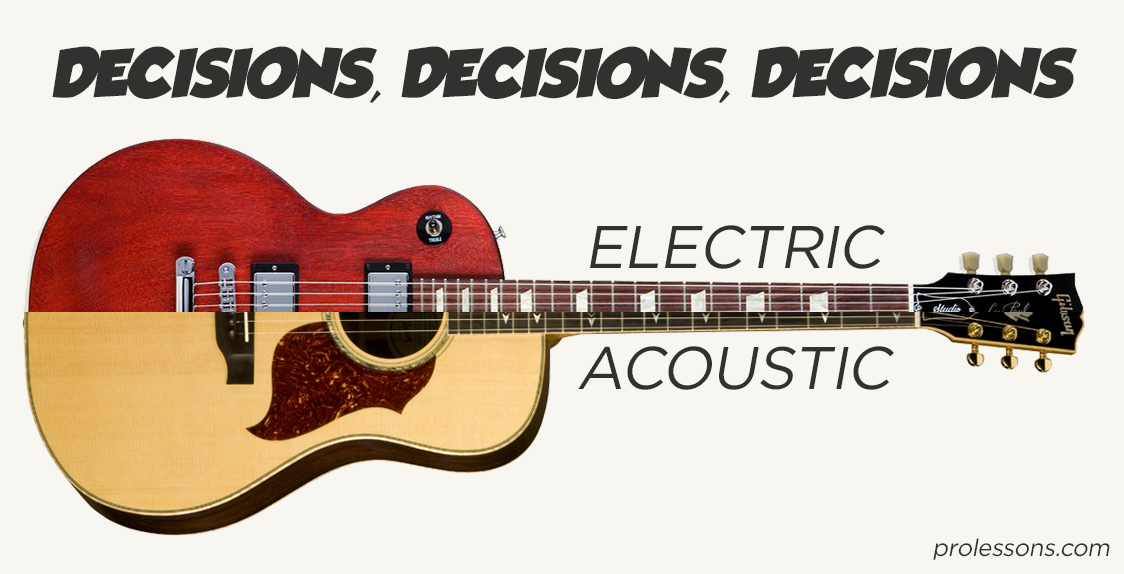

This musical feature is "An estimate of how acoustic a particular song is. Songs with high 'acousticness’ will consist mostly of natural acoustic sounds (think acoustic guitar, piano, orchestra, the unprocessed human voice), while songs with a low 'acousticness’ will consists of mostly electric sounds (think electric guitars, synthesizers, drum machines, auto-tuned vocals and so on)" [1].

It is a float between 0 and 1.

### Explicit 
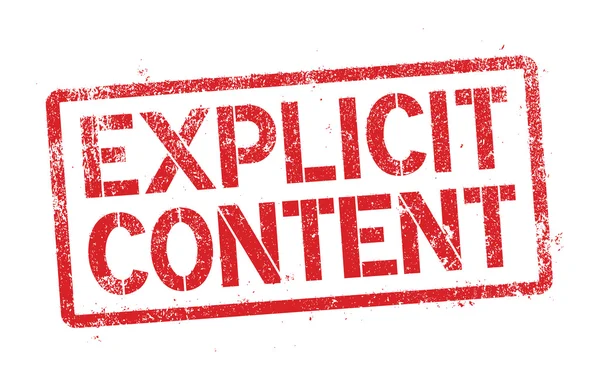

Spotify can sometimes include explicit content, and enables only rights-holders to mark their tracks as such. It is a categorical feature which takes two values, 1 means that the content is explict, 0 means that the content is not explicit.


### Dancebility 
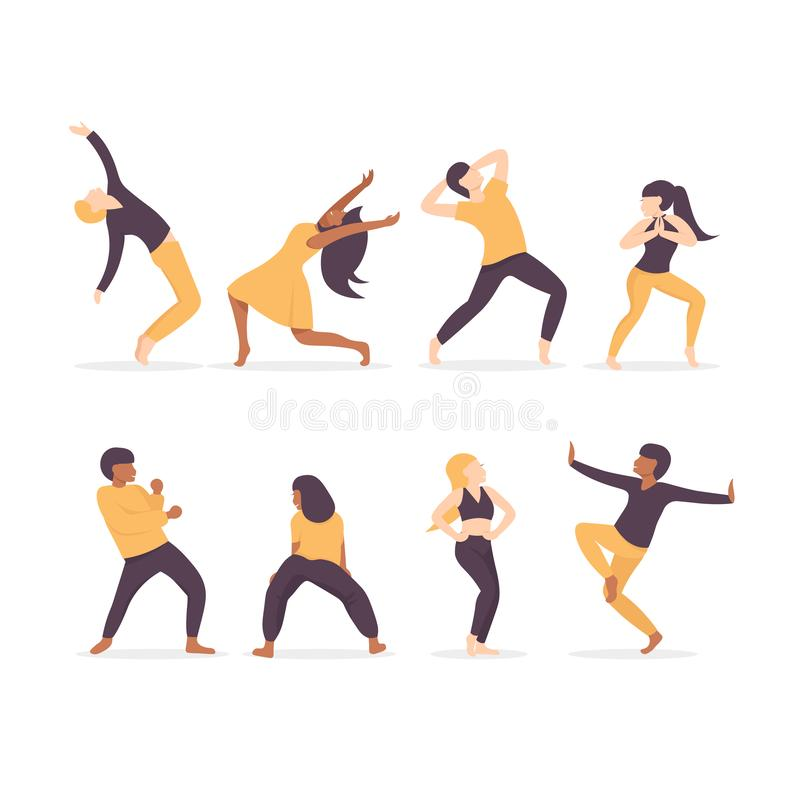
 
This feature describes how suitable a track is for dancing [3].



Text(0.5, 1.0, 'The mean of duration feature for each popularity group')

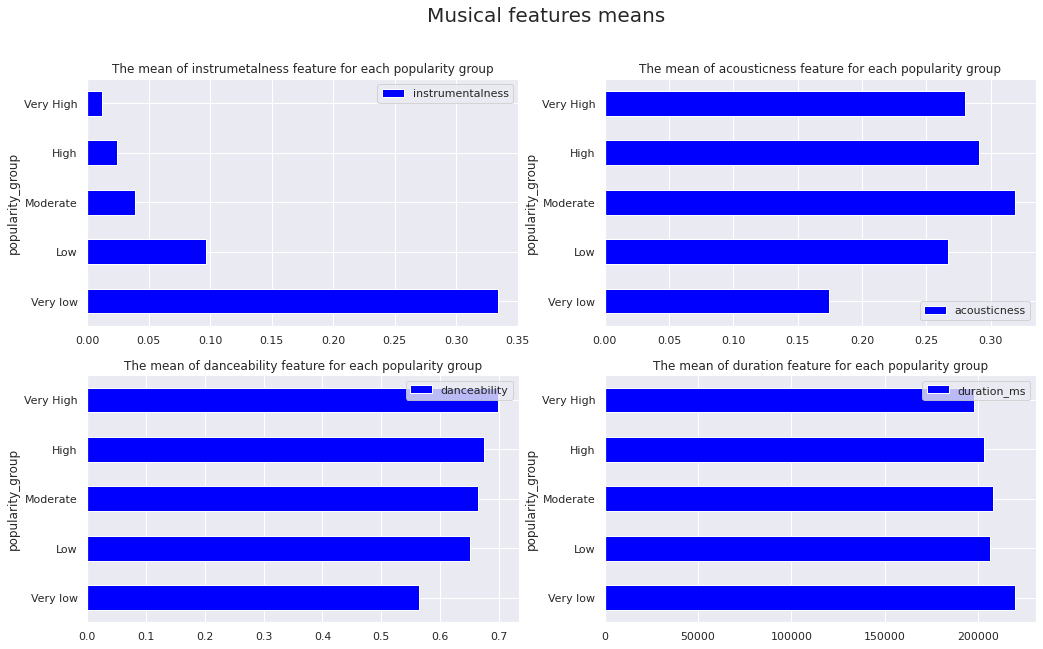

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17, 10))
category_mean.plot(ax=axes[0,0], y='instrumentalness',use_index=True, kind='barh', colormap='brg')
category_mean.plot(ax=axes[0,1],  y='acousticness',use_index=True, kind='barh', colormap='brg')
category_mean.plot(ax=axes[1,0], y='danceability',use_index=True, kind='barh', colormap='brg')
category_mean.plot(ax=axes[1,1],  y='duration_ms',use_index=True, kind='barh', colormap='brg')

# Setting the title of the figure
fig.suptitle('Musical features means', fontsize=20)

# Setting the title of subplots
axes[0,0].set_title('The mean of instrumetalness feature for each popularity group')
axes[0,1].set_title('The mean of acousticness feature for each popularity group')
axes[1,0].set_title('The mean of danceability feature for each popularity group')
axes[1,1].set_title('The mean of duration feature for each popularity group')


Text(0.5, 1.0, 'Probabilty of explicit/non explicit content in each category')

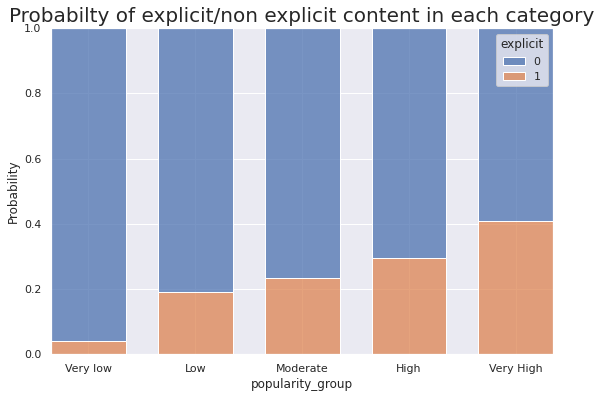

In [ ]:
sns.histplot(df, x="popularity_group", hue="explicit", stat="probability", multiple="fill", shrink=.7)
plt.title('Probabilty of explicit/non explicit content in each category', fontsize=20)


*Interpretation :*   
**Instrumentalness** : The category with very low popularity has the highest rate 
of instrumentalness where the one with very high popularity has the lowest rate of instrumentalness. 

Bad news for composers of instrumental music ; songs with lyrics seem to attract more listeners than instrumental tracks !

**Acousticness** : 
The category with Moderate popularity has the highest acousticness mean. The one with Very low popularity has the lowest rate of acousticness.
Acousticness does not seem to make difference in popularity.

**Danceability** : The most popular categories have the highest means of danceability. Tracks who invite listeners to engage with via their body seem to be more popular ! 

**Explicit** : The most popular categories have more important percentages of explicit content ;) 


According to this statistic analysis, a song with lyrics that makes people dance is closer to popularity than an instrumental track that does not make people dance. It seems also that adult content is a good ingredient 😝 


# 2- Predicting popularity amount of songs from its features - the regression problem

Now, we want to build a regression model that predicts the popularity amount of a track from its musical features.


*   Target variable : popularity
*   Explanatory variables : we will decide it after making analytics that aim to see the correlation between popularity and some other features




## Pairwising relatiships between variables




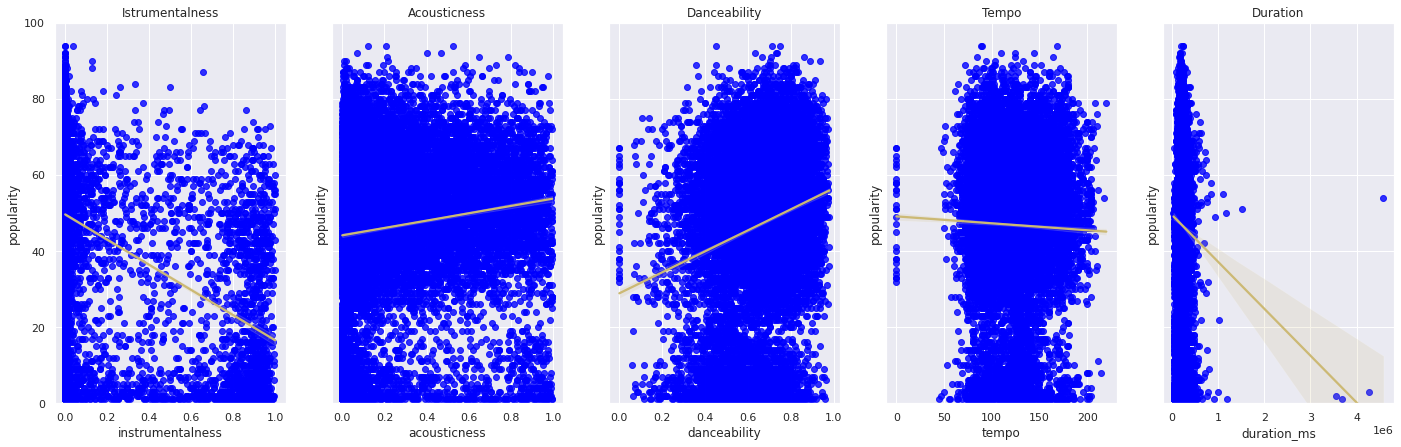

In [ ]:
# Five subplots
f, (ax1, ax2,ax3,ax4, ax5) = plt.subplots(1, 5, figsize=(24, 7), sharey=True)

# Setting the titles of subplots
ax1.set_title('Istrumentalness')
ax2.set_title('Acousticness')
ax3.set_title('Danceability')
ax4.set_title('Tempo')
ax5.set_title('Duration')

# Plotting regplot
sns.regplot(data=df, x='instrumentalness', y='popularity', scatter_kws={"color": "blue"}, line_kws={"color": "y"},ax=ax1)
sns.regplot(data=df, x='acousticness', y='popularity', scatter_kws={"color": "blue"}, line_kws={"color": "y"},ax=ax2)
sns.regplot(data=df, x='danceability', y='popularity', scatter_kws={"color": "blue"}, line_kws={"color": "y"},ax=ax3)
sns.regplot(data=df, x='tempo', y='popularity', scatter_kws={"color": "blue"}, line_kws={"color": "y"},ax=ax4)
sns.regplot(data=df, x='duration_ms', y='popularity', scatter_kws={"color": "blue"}, line_kws={"color": "y"},ax=ax5)
plt.ylim(0, 100)
plt.show()

In [ ]:
# Creating a correlation matrix
corr_metrics = df.corr()
corr_metrics.style.background_gradient()

,popularity,duration_ms,explicit,danceability,acousticness,instrumentalness,tempo
popularity,1.000000,-0.055679,0.200584,0.216432,0.134270,-0.396709,-0.026499
duration_ms,-0.055679,1.000000,-0.072559,-0.103368,0.008798,-0.031221,0.007478
explicit,0.200584,-0.072559,1.000000,0.298199,-0.061643,-0.154579,0.000718
danceability,0.216432,-0.103368,0.298199,1.000000,-0.177510,-0.225707,-0.070179
acousticness,0.134270,0.008798,-0.061643,-0.177510,1.000000,-0.045669,-0.111468
instrumentalness,-0.396709,-0.031221,-0.154579,-0.225707,-0.045669,1.000000,0.007553
tempo,-0.026499,0.007478,0.000718,-0.070179,-0.111468,0.007553,1.000000


The most correlated feature to popularity is "instrumentalness", comes next the "danceability", then "explicit". However, "tempo" has nothing to do with popularity, it is the less correlated one.

Let's prepare our dataset for modeling :


*   Matrix containing the model's features : we will keep only 'explicit','danceability', 'acousticness' and 'instrumentalness'.
*   Vector containing the model's labels : popularity, as we need labels in supervised learning !

*   Train and test data 






In [ ]:
# Creating features
features = df.drop(columns=['id','name','artists','release_date', 'key','popularity_group','tempo','duration_ms','popularity'],axis=1)
X = features.values

# Creating labels
Y = df['popularity'].values

# Spliting data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=10)

# Instantiating the model
reg = LinearRegression()

# Fiting the model to the data
reg.fit(X_train, Y_train)

# Making predictions
Y_pred = reg.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(Y_pred[:5], Y_test[:5]))

Predictions: [55.36532632 49.99438467 46.61428296 51.9323148  48.60416312], Actual Values: [62 53 12  1 41]


We have now a fit model that uses multiple feature from our dataset, and makes predictions of popularity values. We will evaluate his performance using some regression metrics.
 

*   R-squared : a statistical measure of fit that indicates how much variation of a dependent variable ('popularity') is explained by the independent variables ('explicit','danceability', 'acousticness' and 'instrumentalness') in a regression model.
*   RMSE :  the standard deviation of the residuals or prediction errors. Residuals are a measure of how far data points are from the regression line. We can also define it as a measure of how spread out these residuals are.



In [ ]:
# Compute R-squared
r_squared = reg.score(X_test, Y_test)

# Compute RMSE
rmse = mean_squared_error(Y_test, Y_pred, squared=False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.19088359823781675
RMSE: 17.468066506070397


The features explain 19% of the variance in popularity values! 😔

The average distance between the actual popularity values and the predicted popularity values is 17 !

The model performance is dependent on the way the data is splitted up, so it is not representative of the model's ability to generalize to unseen data, that's why we will opt for Cross-validation. 


### Cross Validation

In [ ]:
# Creating a KFold object
kf = KFold(n_splits=6, shuffle=True, random_state=5)

# Instanciating a linear regression model
reg = LinearRegression()

# Computing 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X, Y, cv=kf)

# Printing scores
print(cv_scores)

[0.20538526 0.22069383 0.18792188 0.18681079 0.22430169 0.21620967]


Now we will analyse cross validation results

In [ ]:
# Print the mean and the standard deviation
print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(cv_scores), np.std(cv_scores)))

# Print the 95% confidence interval
print(np.quantile(cv_scores, [0.025, 0.975]))

0.21 accuracy with a standard deviation of 0.01
[0.18694968 0.22385071]


Now we want to regularize the regression. It allows to improve our model to work on unseen data by ignoring the less important features :


*   Ridge Regression 


*   Lasso 



In [ ]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_scores = []
for alpha in alphas:
  
  # Create a Ridge regression model
  ridge = Ridge(alpha=alpha)
  
  # Fit the data
  ridge.fit(X_train, Y_train)
  
  # Obtain R-squared
  score = ridge.score(X_test, Y_test)
  ridge_scores.append(score)
print(ridge_scores)

[0.19088386213989728, 0.19088623419844453, 0.19090965288596906, 0.19111467158298312, 0.191003736200966]


scores don't appear to change much as alpha increases, 

[  5.56488022  12.3681665    9.00154776 -27.48473414]


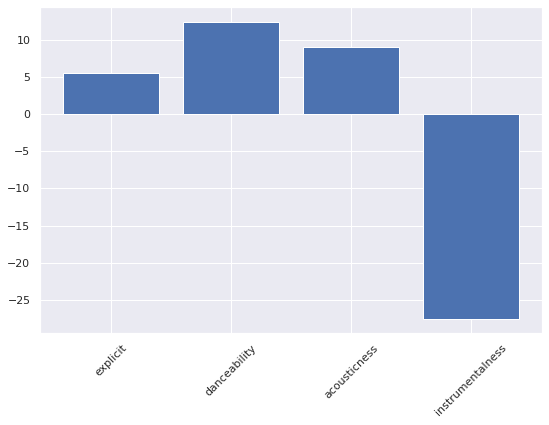

In [ ]:
# Instantiate a lasso regression model
lasso = Lasso(alpha=0.1)

# Fit the model to the data
lasso.fit(X, Y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)
plt.bar(features.columns, lasso_coef)
plt.xticks(rotation=45)
plt.show()

The figure makes it clear that instrumentalness is the most important feature in the dataset to predict popularity values.

Now we will make prediction with lasso !

In [ ]:
# Make predictions with lasso
Y_pred_lasso = lasso.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(Y_pred_lasso[:5], Y_test[:5]))

Predictions: [55.10306694 49.30147092 46.90565908 50.74397736 48.2961355 ], Actual Values: [62 53 12  1 41]


In [ ]:
# Compute RMSE
rmse = mean_squared_error(Y_test, Y_pred_lasso, squared=False)

# Print the metrics
print("RMSE: {}".format(rmse))

RMSE: 17.47031373524515


# 3- Predicting the popularity group of tracks from its features - classification problem

Now, we want to build a classification model that predicts the popularity_group of a track from its musical features.

Target variable : popularity_group

In [ ]:
# selecting rows based on condition 
df_class = df[df['popularity_group'].isin(['Very low','Low','Moderate'])] 
df_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14308 entries, 16219 to 2447
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                14308 non-null  object  
 1   name              14308 non-null  object  
 2   popularity_group  14308 non-null  category
 3   popularity        14308 non-null  int64   
 4   duration_ms       14308 non-null  int64   
 5   explicit          14308 non-null  int64   
 6   artists           14308 non-null  object  
 7   release_date      14308 non-null  object  
 8   danceability      14308 non-null  float64 
 9   key               14308 non-null  object  
 10  acousticness      14308 non-null  float64 
 11  instrumentalness  14308 non-null  float64 
 12  tempo             14308 non-null  float64 
dtypes: category(1), float64(4), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
# Creating features
X_class = df_class.drop(columns=['id','name','artists','release_date', 'key','tempo','duration_ms','popularity','popularity_group'],axis=1)

# Creating labels
Y_class = df_class['popularity_group'].values

# Spliting our data
X_class_train, X_class_test, Y_class_train, Y_class_test = train_test_split(X_class,Y_class, random_state=10)

### Normalizing the feature data

In [ ]:
# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_X_class_train = scaler.fit_transform(X_class_train)
scaled_X_class_test = scaler.transform(X_class_test)

### Principal Component Analysis

Text(0.5, 0, 'Principal Component #')

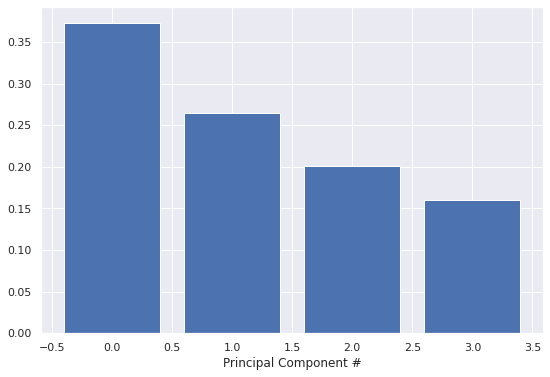

In [ ]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_X_class_train)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method.

But instead, we can look at the cumulative explained variance plot to determine how many features are required to explain about 85% of the variance.
Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.

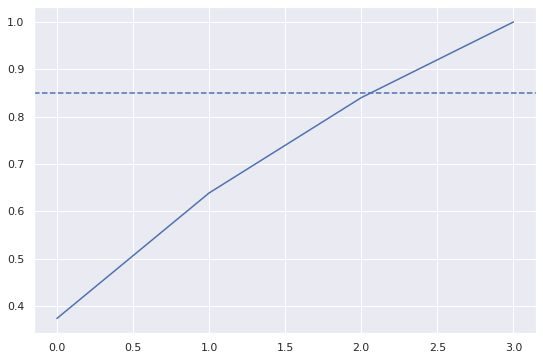

In [ ]:
# Calculating the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Ploting the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [ ]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=3, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_X_class_train)

# Fit and transform the scaled test features using pca
test_pca = pca.fit_transform(scaled_X_class_test)

### DecisionTree

In [ ]:
# Creating our decision tree
tree = DecisionTreeClassifier(random_state=10)

# Training our decision tree
tree.fit(train_pca, Y_class_train)

# Predicting the labels for the test data
pred_labels_tree = tree.predict(test_pca)

### Comparing decision tree to regression and MLP models 

In [ ]:
# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10).fit(X_class_train, Y_class_train)
pred_labels_logit = logreg.predict(X_class_test)

# Train our MLP and predict labels for the test set
mlp = MLPClassifier(random_state=10).fit(X_class_train, Y_class_train)
pred_labels_mlp = mlp.predict(X_class_test)

class_rep_tree = classification_report(Y_class_test,pred_labels_tree)
class_rep_log = classification_report(Y_class_test,pred_labels_logit)
class_rep_mlp = classification_report(Y_class_test,pred_labels_mlp)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("MLP: \n", class_rep_mlp)

Decision Tree: 
               precision    recall  f1-score   support

         Low       0.17      0.24      0.20       643
    Moderate       0.69      0.64      0.66      2278
    Very low       0.39      0.34      0.36       656

    accuracy                           0.51      3577
   macro avg       0.42      0.41      0.41      3577
weighted avg       0.54      0.51      0.52      3577

Logistic Regression: 
               precision    recall  f1-score   support

         Low       0.00      0.00      0.00       643
    Moderate       0.68      0.97      0.80      2278
    Very low       0.66      0.36      0.47       656

    accuracy                           0.68      3577
   macro avg       0.45      0.44      0.42      3577
weighted avg       0.56      0.68      0.60      3577

MLP: 
               precision    recall  f1-score   support

         Low       0.00      0.00      0.00       643
    Moderate       0.71      0.95      0.81      2278
    Very low       0.66     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MLP has the best accuracy (0.70), followed by the Logistic Regression (0.68), but these tow models have a poor performance with the Low popularity class. While Decision tree has the lowest accuracy, but performs better for the Low popularity class.

We can have better performance if we balance our data !

### Balance our data to better performance

In [ ]:
# Subset a balanced proportion of data points
very_low_only = df.loc[df['popularity_group'] == 'Very low']
low_only = df.loc[df['popularity_group'] == 'Low']
moderate_only = df.loc[df['popularity_group'] == 'Moderate']


# subset only the rock songs, and take a sample the same size as there are hip-hop songs
low_only = low_only.sample(very_low_only.shape[0], random_state=10)
moderate_only = moderate_only.sample(very_low_only.shape[0], random_state=10)


# concatenate the dataframes hop_only and rock_only
verylow_low_moderate_bal = pd.concat([very_low_only, low_only, moderate_only])

# The features, labels, and pca projection are created for the balanced dataframe
X = verylow_low_moderate_bal.drop(['id','name','artists','release_date', 'key','tempo','duration_ms','popularity','popularity_group'], axis=1) 
Y = verylow_low_moderate_bal['popularity_group']

# Redefine the train and test set with the pca_projection from the balanced data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(X_train))
test_pca = pca.transform(scaler.transform(X_test))

### Evaluate the new models


In [ ]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, Y_train)
pred_labels_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, Y_train)
pred_labels_logit = logreg.predict(test_pca)

# Train our MLP on the balanced data
mlp = MLPClassifier(random_state=10)
mlp.fit(train_pca, Y_train)
pred_labels_mlp = mlp.predict(test_pca)

# compare the models
print("Decision Tree: \n", classification_report(Y_test, pred_labels_tree))
print("Logistic Regression: \n", classification_report(Y_test, pred_labels_logit))
print("MLP: \n", classification_report(Y_test, pred_labels_mlp))

Decision Tree: 
               precision    recall  f1-score   support

         Low       0.39      0.41      0.40       626
    Moderate       0.44      0.43      0.44       603
    Very low       0.59      0.58      0.58       643

    accuracy                           0.47      1872
   macro avg       0.47      0.47      0.47      1872
weighted avg       0.47      0.47      0.47      1872

Logistic Regression: 
               precision    recall  f1-score   support

         Low       0.38      0.18      0.24       626
    Moderate       0.46      0.68      0.55       603
    Very low       0.61      0.65      0.63       643

    accuracy                           0.50      1872
   macro avg       0.48      0.50      0.47      1872
weighted avg       0.48      0.50      0.47      1872

MLP: 
               precision    recall  f1-score   support

         Low       0.48      0.14      0.21       626
    Moderate       0.45      0.78      0.57       603
    Very low       0.65     

### Cross validation

In [ ]:
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=3)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=3)), 
                        ("logreg", LogisticRegression(random_state=10))])
mlp_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=3)), 
                        ("mlp", MLPClassifier(random_state=10))])

# Set up our K-fold cross-validation
kf = KFold(9)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, X, Y, cv=kf)
logit_score = cross_val_score(logreg_pipe, X, Y, cv=kf)
mlp_score = cross_val_score(logreg_pipe, X, Y, cv=kf)

# Print the mean of each array o scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score), "MLP:", np.mean(mlp_score))

Decision Tree: 0.38635792398202146 Logistic Regression: 0.1833836665740998 MLP: 0.1833836665740998
